# Phase II: Data Curation, Exploratory Analysis and Plotting

Expresses the central motivation of the project and explains the (at least) two key questions to be explored. Gives a summary of the data processing pipeline so a technical expert can easily follow along. (1%)

### Problem Motivation

Movies have been around for decades and as a result there has been numerous movies released into the market with many more being released each year. With such a large number of movies out, it may be hard to objectively know if a certain movie is objectively good and, as a result, succesful. Due to this, we seek to look at and analyze specific traits and characteristics of movies such as their budget, average rating, popularity and even populatiry of the actors to get a better look into what exactly makes a movie so good/successful.

#### Key Questions:

Are popularity and average ratings correlated? In other words, if a movie is simply more popular does it mean the ratings, an indicator of how successful a movie is, are on average higher?

Does release date of the movie impact popularity or ratings? Is releasing a movie during a specific season/time period more beneficial to how successful it is

Which genres appear to be more appealing? More specifically, which genres seem to be more popular and thus possibly indicate that a movie might could be successful?

Is the budget of the movie indicative of how successful a movie is?

### Data Processing Pipeline Summary

#### Obtains, cleans, and merges all data sources involved in the project. (2%)

Imports

In [1]:
import requests
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt

Obtaining Data

In [2]:
api_key = "03bcc17f7d105b13199e0325b659d4ab"
API_KEY = "6c30ec8965840313bb630941ccabc149"
BASE_URL = "https://api.themoviedb.org/3"

# Function to get movie details by ID
def get_movie_details(movie_id):
    """
    Gets the movie details of a movie through a movie id.

    Args:
        movie_id (string): the id of the movie as a string.
    
    Returns:
        response: the reponse (as a json) recieved.
    """
    url = f"{BASE_URL}/movie/{movie_id}?api_key={API_KEY}"
    response = requests.get(url)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching details for movie ID {movie_id}: {response.status_code}")
        return None

# Function to get movie credits by ID
def get_movie_credits(movie_id):
    """
    Gets the movie credits of a movie through a movie id.

    Args:
        movie_id (string): the id of the movie as a string.
    
    Returns:
        response: the reponse (as a json) recieved.
    """
    url = f"{BASE_URL}/movie/{movie_id}/credits?api_key={API_KEY}"
    response = requests.get(url)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching credits for movie ID {movie_id}: {response.status_code}")
        return None

# Function to get actor popularity by ID
def get_actor_popularity(actor_id):
    """
    Gets the popularity of an actor through an actor id.

    Args:
        actor_id (string): the id of the actor as a string.
    
    Returns:
        response: the popularity of the actor.
    """
    url = f"{BASE_URL}/person/{actor_id}?api_key={API_KEY}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        return data.get('popularity')
    else:
      print(f"Error fetching popularity for actor ID {actor_id}: {response.status_code}")
      return None

page = 1
df = pd.DataFrame()
for i in range(50): #the number of pages to go up until
    url = f"{BASE_URL}/movie/top_rated?api_key={api_key}&language=en-US&page={page}"

    response = requests.get(url)
    data = response.json()

    new_data = pd.DataFrame(data['results'])

    df = pd.concat([df, new_data])
    page += 1

# Filter out movies with vote count less than 1000
df = df[df['vote_count'] >= 1000].copy() # Use .copy() to avoid SettingWithCopyWarning

# Add budget information
df['budget'] = None
for index, row in df.iterrows():
    movie_id = row['id']
    details = get_movie_details(movie_id)
    if details and 'budget' in details:
        df.loc[index, 'budget'] = details['budget']
    time.sleep(0.05) # Add a small delay to avoid hitting API limits

# Add top actor popularity
df['top_actor_popularity (out of 10)'] = None # Initialize top_actor_popularity column
for index, row in df.iterrows():
    movie_id = row['id']
    credits = get_movie_credits(movie_id)
    if credits and 'cast' in credits and len(credits['cast']) > 0:
        top_actor_id = credits['cast'][0]['id']
        actor_popularity = get_actor_popularity(top_actor_id)
        df.loc[index, 'top_actor_popularity (out of 10)'] = actor_popularity
    time.sleep(0.05) # Add a small delay to avoid hitting API limits


# Convertin budget to millions n dropping orginal budget column
df['budget_in_millions'] = df['budget'] / 1000000
df = df.drop(columns=['budget'])

df.head()


,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count,top_actor_popularity (out of 10),budget_in_millions
0,False,/v8xVDqt8uCul3c3mgx4VpGCwxJC.jpg,"[18, 80]",278,en,The Shawshank Redemption,Imprisoned in the 1940s for the double murder ...,36.0606,/9cqNxx0GxF0bflZmeSMuL5tnGzr.jpg,1994-09-23,The Shawshank Redemption,False,8.712,29085,1.0169,0.531374
1,False,/jdHsptJbtalEuVhCV5i7kSC3g0x.jpg,"[18, 80]",238,en,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",35.0280,/3bhkrj58Vtu7enYsRolD1fZdja1.jpg,1972-03-14,The Godfather,False,8.685,21972,0.7537,7.275
2,False,/kGzFbGhp99zva6oZODW5atUtnqi.jpg,"[18, 80]",240,en,The Godfather Part II,In the continuing saga of the Corleone crime f...,21.0770,/hek3koDUyRQk7FIhPXsa6mT2Zc3.jpg,1974-12-20,The Godfather Part II,False,8.571,13277,4.0856,30.0
3,False,/zb6fM1CX41D9rF9hdgclu0peUmy.jpg,"[18, 36, 10752]",424,en,Schindler's List,The true story of how businessman Oskar Schind...,17.7591,/sF1U4EUQS8YHUYjNl3pMGNIQyr0.jpg,1993-12-15,Schindler's List,False,8.566,16798,2.5317,6.5
4,False,/tj6iPnz18hGfr0LKqWmG6Cp3niO.jpg,[18],389,en,12 Angry Men,The defense and the prosecution have rested an...,13.4176,/ow3wq89wM8qd5X7hWKxiRfsFf9C.jpg,1957-04-10,12 Angry Men,False,8.500,9475,3.184,14.6


Cleans Data

In [3]:
def get_languages():
    """
    This function gets the list of movie languages from the TMDB.
    
    Returns:
        response (dict): The list of languages as a dictionary.
    """
    url = "https://api.themoviedb.org/3/configuration/languages"
    params = {"api_key": api_key}
    headers = {"accept": "application/json"}

    response = requests.get(url, headers=headers, params=params)
    return response.json()

def get_movie_genres():
    """
    This funciton gets the list of movie genres from the TMDB.
    
    Returns:
        response (dict): The list of genres as a dictionary.
    """
    url = "https://api.themoviedb.org/3/genre/movie/list?language=en"
    params = {"api_key": api_key}
    headers = {"accept": "application/json"}
    response = requests.get(url, headers=headers, params=params)

    return response.json()

def clean_data(df):
    """
    Cleans the data given into these metrics: 
        - id
        - title
        - popularity
        - rating
        - number_of_raters
        - top_actor_popularity (out of 10)
        - budget_in_millions
        - release_year
        - release_month
        - release_day 
        - original language (as dummy variables in int (1) format)
        - genres (as dummy variables in int (1) format)

    Args:
        df (DataFrame): the inputted dataframe to be cleaned.

    Returns:
        cleaned_df (DataFrame): a cleaned dataframe.
    """
    
    #get the list of languages from TMDB
    languages_dict = get_languages()
    languages = {}
    for lang in languages_dict:
        languages[lang['iso_639_1']] = lang['english_name']
    
    #get the list of genres from TMDB
    genres_dict = get_movie_genres()
    genre_list = {}
    for genre in genres_dict['genres']:
        genre_list[genre['id']] = genre['name']

    #initialize lists to hold data
    movie_ids = []
    movie_titles = []
    movie_year = []
    movie_month = []
    movie_day = []
    movie_language = []
    movie_popularity = []
    movie_genres = []
    movie_vote_average = []
    movie_vote_count = []
    movie_budget = []
    movie_top_actor_popularity = []

    #loop through all rows of the data
    for data in df.iterrows():
        movie = data[1]

        movie_ids.append(movie['id']) #append movie id

        movie_titles.append(movie['title']) #append movie title

        #append movie release date
        movie_year.append(int(movie['release_date'][0:4])) 
        movie_month.append(int(movie['release_date'][5:7]))
        movie_day.append(int(movie['release_date'][8:10]))

        movie_language.append(languages[movie['original_language']]) #append movie language

        movie_popularity.append(float(movie['popularity'])) #append movie popularity

        #append movie genres as a list of genres
        genres = movie['genre_ids']
        list_of_genres = []
        for index in genres:
            list_of_genres.append(genre_list[index])
        movie_genres.append(list_of_genres)

        #append movie rating average and count
        movie_vote_average.append(float(movie['vote_average']))
        movie_vote_count.append(int(movie['vote_count']))

        movie_budget.append(round(float(movie['budget_in_millions']), 3)) #append movie budget in millions (rounded to 3 decimal places)

        movie_top_actor_popularity.append(movie['top_actor_popularity (out of 10)']) #append top actor popularity

    #put all of the lists into a dictionary
    df_dict = {'movie_id': movie_ids,
               'title': movie_titles,
               'popularity': movie_popularity,
               'rating': movie_vote_average,
               'number_of_raters': movie_vote_count,
               'top_actor_popularity (out of 10)': movie_top_actor_popularity,
               'budget_in_millions': movie_budget,
               'genres': movie_genres,
               'release_year': movie_year,
               'release_month': movie_month,
               'release_day': movie_day,
               'original_language': movie_language,
               }

    cleaned_df = pd.DataFrame(df_dict) #create the dataframe

    #make dummy variables for categorical data
    cleaned_df = pd.get_dummies(cleaned_df, columns=['original_language'], dtype='int')

    df_exploded = cleaned_df.explode('genres') #explode the genres column so each genre has its own row (we'll remove these extra rows later)
    df_genre_dummies = pd.get_dummies(df_exploded['genres']) #get the dummy variables for the genres
    cleaned_df = cleaned_df.join(df_genre_dummies.groupby(df_exploded.index).sum()) #put rows back together again

    cleaned_df = cleaned_df.drop(columns=['genres']) #drop the genres column now, as we don't need it

    cleaned_df = cleaned_df.sort_values(by='movie_id') #sort the dataframe by movie_id (this isn't really necessary)
    return cleaned_df.reset_index(drop=True) #return the dataframe, and reset the index of the rows

cleaned_df = clean_data(df)
cleaned_df


,movie_id,title,popularity,rating,number_of_raters,top_actor_popularity (out of 10),budget_in_millions,release_year,release_month,release_day,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,11,Star Wars,19.9232,8.204,21589,1.7587,17.0,1977,5,25,...,0,0,0,0,0,1,0,0,0,0
1,12,Finding Nemo,19.2071,7.816,19999,4.3543,200.0,2003,5,30,...,0,0,0,0,0,0,0,0,0,0
2,13,Forrest Gump,22.9472,8.464,28756,2.0537,3.5,1994,6,23,...,0,0,0,0,1,0,0,0,0,0
3,14,American Beauty,9.5496,8.003,12605,4.8023,0.0,1999,9,15,...,0,0,0,0,0,0,0,0,0,0
4,15,Citizen Kane,8.2260,8.000,5786,4.0856,30.0,1941,4,17,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,1054867,One Battle After Another,68.4089,7.700,1008,3.6069,81.0,2025,9,23,...,0,0,0,0,0,0,0,1,0,0
613,1054867,One Battle After Another,72.4844,7.734,1008,1.2707,1.8,2025,9,23,...,0,0,0,0,0,0,0,1,0,0
614,1084736,The Count of Monte Cristo,12.9377,7.965,1797,3.8841,30.0,2024,6,28,...,0,0,0,0,0,0,0,0,0,0
615,1087192,How to Train Your Dragon,70.0209,8.012,2088,3.3546,76.0,2025,6,6,...,0,0,0,0,0,0,0,0,0,0


#### Builds at least two visualizations (graphs/plots) from the data which help to understand or answer the questions of interest. These visualizations will be graded based on how much information they can effectively communicate to readers. Please make sure your visualization are sufficiently distinct from each other. (2%)

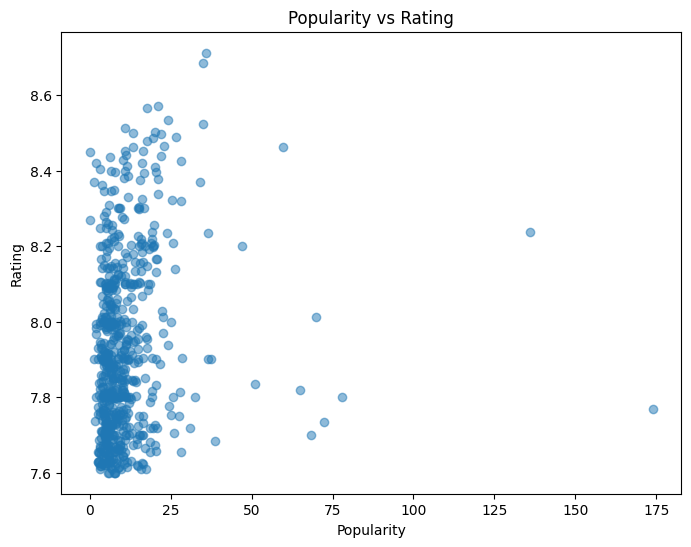

In [4]:
# plot for popularity vs rating to analyze if popularity and average ratings are correlated 
dfpr = cleaned_df.dropna(subset=["popularity","rating","number_of_raters"])

# create a new figure w/ width/height dimensions 8 and 6
plt.figure(figsize=(8,6))

# draw scatterplot w/ popularity as x and rating as y
plt.scatter(dfpr["popularity"], dfpr["rating"], alpha=.5)

# labels x as "Popularity"
plt.xlabel("Popularity")

# labels y as "Rating"
plt.ylabel("Rating")

# gives plot title
plt.title("Popularity vs Rating")

#displays plot
plt.show()




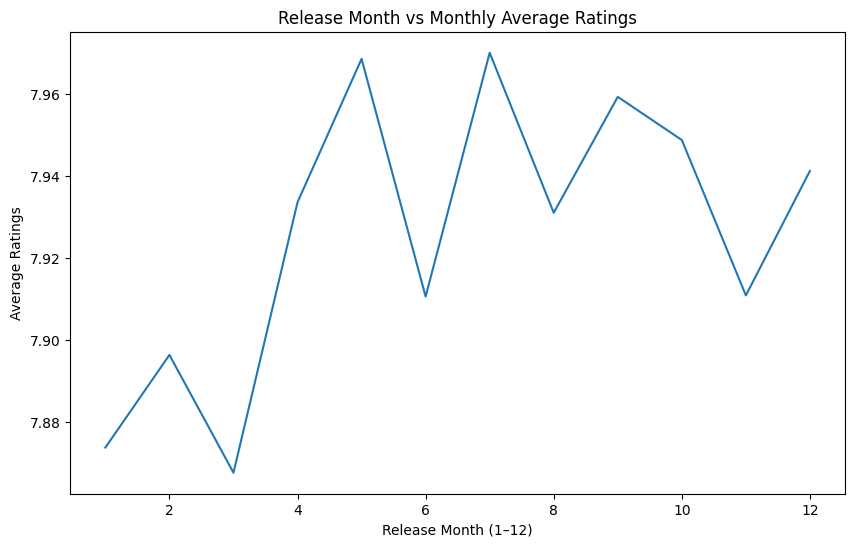

In [5]:
# keep rows that contain given columns 
df_rt = cleaned_df.dropna(subset=["release_month", "rating", "popularity"])

# create a new figure w/ width/height dimensions 10 and 6
plt.figure(figsize=(10,6))

# compute the monthly average rating
avg_rating = df_rt.groupby("release_month")["rating"].mean()

# plots month with respective average rating
plt.plot(avg_rating.index, avg_rating.values)

# labels x as "Release Month (1–12)"
plt.xlabel("Release Month (1–12)")

# labels y as "Average Ratings"
plt.ylabel("Average Ratings")

# title for line plot
plt.title("Release Month vs Monthly Average Ratings")

#displays plot
plt.show()
